# Artificial Neural Networks

Artifical neural networks (ANNs) are applied as a supervised learning technique to classify data into known classes.

![SegmentLocal](Images/curve_fit.png "curvefit")


\begin{align}
y & = W_1\,x^4 + W_2\,x^3 + W_3\,x^2 + W_4\,x + W_5\\
\end{align}

You can think of them as a cousin of familiar curve-fitting, but taken to higher dimensions. For example, when fitting a polynomial curve to a dataset we learn the values of the coefficients $W$ so that the model curve can accurately predict an outcome given input data. Similarly, for an ANN classifier, we learn a set of weights (coefficients) between the neurons so the the network can accurately predict a label for input training data.

![SegmentLocal](Images/ANN_1layer.svg "ANN1")

In both cases the fitting procedure employs a measure of how well model performs. For curve fitting the distance between the data and model is minimised (e.g., $\chi^2$ or least-squared distance), while for an ANN classifier a *loss function* is minimised.

When training the classifier, the loss function desires the following state:

<img src="Images/loss_margin.jpg">

Scores inside the red region (or higher) will accumulate a loss, while scores below will accumulate zero loss.

Some articles I found helpful: a high-level description at [this link](https://becominghuman.ai/understanding-neural-networks-1-the-concept-of-neurons-287be36d40f), more detail at [this link](https://towardsdatascience.com/understanding-neural-networks-19020b758230) and [this link](http://neuralnetworksanddeeplearning.com/chap1.html).

## Stochastic Gradient Descent and mini-batches

Minimisation is done iteratively via gradient descent:
 * Randomly initialise the weights between neurons
 * assess the performance of the network using the loss function
 * examine the slope of the loss surface and jump 'down-hill'
 * rinse and repeat until no improvement is seen

![SegmentLocal](Images/grad_descent.gif "descent")

This is superficially similar fitting a polynomial curve, however, there are two major differences:
 1. the weight coefficients are not independent - the output of neurons are affected by all in the chain before them
 1. the very large datasets required by ANNs will not fit in memory
 
The first probem is addressed by back-propagating the gradients using the chain-rule. The second problem is solved by only training on a subset of the data, called a 'mini-batch' (or just 'batch'), and randomly changing the selection of this data every cycle.

## Implementing ANNs using Keras

In the last 10 years there has been an explosion in the availability of software for [deep learning](https://en.wikipedia.org/wiki/Comparison_of_deep-learning_software). One of the most popular is [Keras](https://keras.io/), which is a layer on top of Google's [TensorFlow](https://www.tensorflow.org/versions) machine learning and matrix manipulation library. (Alternatives are PyTorch, developed by Facebook, and CNTK by Microsoft). 

Performing the gradient descent step on even moderately large ANNs requires very intensive calculations. TensorFlow (and Keras) can take advantage of the parallel processing power offered by Graphics Processing Units (GPUs) to vastly accelerate the training step.


## Classifying handwriting - the MNIST dataset

Historically, one of the simplest tasks ANNs were applied to was handwriting recognition. In this notebook we will build an ANN to classify small images of handwritten digits [0 - 9]. This is a classic entry-level problem in machine learning.

The Modified National Institute of Standards and Technology (MNIST) dataset contains 60,000 training images and 10,000 testing images of handwritten digits as 28x28 pixel black & white images.

![SegmentLocal](Images/MNIST_grid.png "MNIST_grid")

These images are encoded with intensity values [0 - 255], so we usually scale them [0 - 1] by dividing by 255.0.

### Coding the classifier

Here we build a simple neural network classifier with two 'hidden layers'. The number of neurons in the *input layer* corresponds to each pixel of an image fed into the network. The number of neurons in the *output layer* corresponds to the possible classes.

![SegmentLocal](Images/ANN_2layers.png "ANN2")

For convenience the MNIST data is stored on disk as a Numpy save file containing a 3D array (images) or 1D array (labels 0 - 9). It is small enough to fit into memory. In this case, the data is already split into training and test sets.

In [1]:
import numpy as np

# Load the training images and labels from Numpy save files
trainX = np.load('DATA/minimnist/train_images.npy')
trainY = np.load('DATA/minimnist/train_labels.npy')

#take a look at the shapes to see what we're dealing with.
print("Training array shape:", trainX.shape)
print("Labels shape", trainY.shape)

Training array shape: (20000, 28, 28)
Labels shape (20000,)


In [2]:
# Load the testing images and labels from Numpy save files
#Later, these will also be referred to as the "validation" set.
testX = np.load('DATA/minimnist/test_images.npy')
testY = np.load('DATA/minimnist/test_labels.npy')
print("Testing array shape:", testX.shape)
print("Labels shape", testY.shape)

Testing array shape: (5000, 28, 28)
Labels shape (5000,)


Let's plot an individual image and display some statistics of the inetensity:

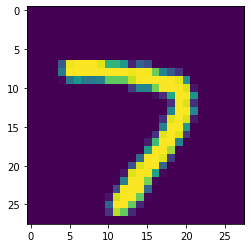

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show a randomly chosen image
img = testX[17,:,:]
plt.imshow(img);

In [4]:
# Determine some stats and print -- we need to know these for later on when we renormalise the data in 
#preparation for the ANN.
print("Min intensity = ", np.nanmin(img)) #what's the minimum value in the images?
print("Max intensity = ", np.nanmax(img)) #maximum?
print("Image label = ", testY[17])
print("Encoding = ", img.dtype)#number of different types of datasets in np.array. We have used floating points a lot
                              # (single and double precision), uint is an 8-bit unsigned integer. Standard type for 
                             # pngs. Later, we will convert to float.

Min intensity =  0
Max intensity =  255
Image label =  7
Encoding =  uint8


Both the training and test data should be converted into floating point precision and scaled into the range [0 - 1]. Machine learning algorithms tend to expect data in this format, unless otherwise specified.

In [5]:
#Convert into float and rescale the intensities [0, 1]
#astype can be used on all numpy arrays to change type.
trainX = trainX.astype("float")  /255.0
testX = testX.astype("float")  /255.0
#check this worked.
print("Min intensity = ", np.nanmin(trainX[17]))
print("Max intensity = ", np.nanmax(trainX[17]))

Min intensity =  0.0
Max intensity =  1.0


We need to re-encode our labels as one-hot vectors. Previously, we've had single-integer labels that classify datapoints as 0 or 1. Here, we need to do things slightly differently, but still using 1s and 0s.

E.g., we have a vector with 3 values in the range 0-9: $x=[2, 4, 8]$. To label these with 1-hot vectors, we need a 2D array with 3 rows (one for each value) by 10 columns (1 for each possible value from 0-9):

lab = [[0,0,1,0,0,0,0,0,0,0,0],\
          [0,0,0,0,1,0,0,0,0,0,0],\
          [0,0,0,0,0,0,0,0,1,0,0]]
          

This "binarizes" our labels, which is the format required for future code. Thankfully, there is a preprocessing class 
in scikit learn called LabelBinarizer that does this for us.

In [6]:
from sklearn.preprocessing import LabelBinarizer

# Create one-hot label vectors

#create instance of class (no arguments required here)
lb = LabelBinarizer()

#not fitting, but this is the name of the function that converts our 
#labels (0-9) into the one-hot vector format required. can use either
#fit_transform, or transform.
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# Show that we have done the converson OK -- recall above index 17 showed image of number 7.
print(testY[17])
indx = np.argwhere(testY[17])#argwhere returns the indexes of an array thart are non-zero 
lb.classes_[indx]#classes_ is the key that returns the class value for our binary labels.

[0 0 0 0 0 0 0 1 0 0]


array([[7]], dtype=uint8)

In [7]:
trainY.shape

(20000, 10)

We also need to flatten each image into a vector of 784 pixels so that it can be injected into the bottom layer of the network.

In [8]:
# Reshape the train and test image stacks
#ANNs take in 1D datasets, so need to transfrom our 2D images.
#set variable dim which gives the shape of the dataset
dim=trainX.shape

#now let's reshape the dataset into a 20,000 image by 784 pixel array
trainX = trainX.reshape((-1, dim[1]*dim[2]))
testX = testX.reshape((-1, dim[1]*dim[2]))

#take a look at the new shape
print(trainX.shape)

(20000, 784)


Now it is time to define the architecture of our network. Keras supports the creation of complicated networks with multiple input or output branchs. However, we will define a simple straight-through "Sequential" network with two hidden layers containing 256 and 128 neurons, respectively. There should be 784 input neurons corresponding to the number of pixels in an image (28 * 28) and 10 output neurons, one for each digit.

In Keras, the 'Dense' layer represents a layer of neurons where each neuron will be connected to all other neurons in layers immediately above and below. 

The activation function scales the output of the neuron in a non-linear way, allowing the network to model non-linear systems.

![SegmentLocal](Images/SigmoidFunction.png "sigmoid")

In [9]:
#As outlined above, there are a number of different models to define a NN. You can have pretty complicated joins 
#between inputs, hidden layers, and outputs. The most simple is a Sequential network, where you push data in one end, 
#and get an output at the other end.
from keras.models import Sequential
from keras.layers import Dense #NNs are made up of many "layers" (input, hidden layers, output), and there are 
                                    #many ways of joining those layers. A dense layer is the simplest: every neuron in
                                    #every layer is joined to the previous and next layer of neurons.

# Define 784-256-128-10 architecture using Keras
#model architecture is somewhat arbitratrily defined here, but the values
#that are used often depend on the dataset at hand -- lots of "rules of thumb" used to
#define these numbers. There is no hard solution -- often it comes down to hard-earned
#experience. Of course, the final output layer must be equal to the number of classifications
#that you want to make, so that is set to 10 here.
model = Sequential()
#you can also add an input layer here that can do the flattening that we did above (not required here, though).

#we need to tell the model to use a sigmoid activation function for the two hidden layers.
model.add(Dense(256, input_shape=(784,), activation="sigmoid"))
model.add(Dense(128, activation="sigmoid"))#here it will auto-default to the previously defined layer for the input_shape
model.add(Dense(10, activation="softmax"))
#Final output layer has a different activation function called softmax. This outputs a probability that the input 
#belongs to a certain class. Sigmoid outputs are independant and are not constrained to sum to 1, thus not great for 
#final output. On the other hand, Softmax is often used as the activation for the last layer of a classification 
#network because the result could be interpreted as a probability distribution (they sum to one).

Using TensorFlow backend.
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mq20150564/software/anaconda2/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype

Once the model has been defined we need to pick a loss function to assess its performance and run the gradient descent algorithm. There are also a number of tweaked optimiser algorithms available, however SGD works fine as a default. 

The optimiser also accepts a 'learning rate', a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

At this point we also need to choose a batch size (how much data can we fit in memory?) and number of epochs to train for (how many times we push a training set through the network to train it).

In [10]:
#NOTE WELL: ON COLAB, THE KERAS OPTIMIZERS HAVE MOVED INTO TENSORFLOW.
#TO IMPORT ON COLAB, NEED TO UNCOMMENT BELOW AND REMOVE LAPTOP VERSION:
#from tensorflow.keras.optimizers import SGD #stochastic gradient descent when on colab
from keras.optimizers import SGD #Stochastic Gradient Descent

# Typical learning rate for SGD
learnRate = 0.01#tells the code how far to randomly jump when updating weights in order to find the next downhill 
                #position for gradient descent. For more complicated problems, can make it smaller. There is a 
                #trade-off between speed and accuracy. Smaller values give more accurate results, but are slower.
opt = SGD(learnRate)

#can also optionally feed it "momentum" (value between 0 and 1), which controls how quickly it accelerates in 
#downhill directions, and helps to control oscillatory behaviour that can hinder the process.


#Now compile the model
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])
#Loss function is like the chi^2 that we used before. Lets the network know how well its doing in terms of identifying
#the correct labels for the training set.

#Also want to measure the performance. Here use accuracy. 
#Recall metrics in week 9 -- accuracy gives the number of correct predictions given known classifications.

# Then run the stochastic gradient descent algorithm to train the model using the training data. Also input
#the vaidation (test) data. Recall trainX are the images (flattened), trainY are the one-hot binarized labels.
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              epochs=100, batch_size=64)

#Epoch sets the number of times the training is iterated. At each iteration, improve the fit by adjusting
#the weights, measure how well that did using the loss function, then use gradient descent to tell
#the weights to change in a certain direction. 

#Batch size tells the code how many of the training images should be sent through the trainer for each gradient
#update within an epoch. 64 in this case, but depends on how much ram you have.



Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 3s 135us/step - loss: 2.2923 - accuracy: 0.1313 - val_loss: 2.2724 - val_accuracy: 0.1474
Epoch 2/100
20000/20000 [==============================] - 2s 112us/step - loss: 2.2479 - accuracy: 0.2783 - val_loss: 2.2321 - val_accuracy: 0.3348
Epoch 3/100
20000/20000 [==============================] - 2s 116us/step - loss: 2.2026 - accuracy: 0.3597 - val_loss: 2.1856 - val_accuracy: 0.3124
Epoch 4/100
20000/20000 [==============================] - 2s 110us/step - loss: 2.1466 - accuracy: 0.4491 - val_loss: 2.1287 - val_accuracy: 0.5588
Epoch 5/100
20000/20000 [==============================] - 2s 108us/step - loss: 2.0748 - accuracy: 0.5347 - val_loss: 2.0513 - val_accuracy: 0.4990
Epoch 6/100
20000/20000 [==============================] - 2s 109us/step - loss: 1.9813 - accuracy: 0.5730 - val_loss: 1.9533 - val_accuracy: 0.5684
Epoch 7/100
20000/20000 [==============================]

Epoch 54/100
20000/20000 [==============================] - 2s 110us/step - loss: 0.3651 - accuracy: 0.8984 - val_loss: 0.4490 - val_accuracy: 0.8672
Epoch 55/100
20000/20000 [==============================] - 2s 110us/step - loss: 0.3624 - accuracy: 0.8999 - val_loss: 0.4458 - val_accuracy: 0.8704
Epoch 56/100
20000/20000 [==============================] - 2s 110us/step - loss: 0.3596 - accuracy: 0.9006 - val_loss: 0.4428 - val_accuracy: 0.8710
Epoch 57/100
20000/20000 [==============================] - 2s 109us/step - loss: 0.3570 - accuracy: 0.9010 - val_loss: 0.4399 - val_accuracy: 0.8702
Epoch 58/100
20000/20000 [==============================] - 2s 108us/step - loss: 0.3545 - accuracy: 0.9017 - val_loss: 0.4382 - val_accuracy: 0.8718
Epoch 59/100
20000/20000 [==============================] - 2s 106us/step - loss: 0.3522 - accuracy: 0.9027 - val_loss: 0.4353 - val_accuracy: 0.8728
Epoch 60/100
20000/20000 [==============================] - 2s 107us/step - loss: 0.3498 - accuracy:

That's it! Training has finished and our model is ready to make prediction about the testing data. Let's just make a prediction about one image to illustrate.

Model expects this shape data: (1, 784)


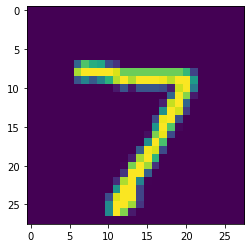

In [11]:
# Select a single image - a batch of 1
testX_1 = testX[0].reshape(1, 784)
print("Model expects this shape data:",testX_1.shape)

# Plot the image
plt.imshow(testX_1[0].reshape(28, 28))

In [12]:
# Make a prediction for the selected image using our trained model.
predictions = model.predict(testX_1, batch_size=1)
print("\nPredictions are a vector of probabilities:\n", predictions)


Predictions are a vector of probabilities:
 [[2.5648423e-04 2.3251216e-06 1.8067651e-04 2.5522979e-03 4.2780503e-06
  1.3061261e-04 2.1550832e-08 9.9449122e-01 2.1293939e-05 2.3608217e-03]]


In [13]:
# Select index of the highest probability
indx = np.argmax(predictions)
print("\nPredicted digit is", lb.classes_[indx])


Predicted digit is 7


Scikit learn comes with a handy function to report useful classification statistics:

In [14]:
from sklearn.metrics import classification_report

# Make predictions on all the 5000 images in the test data
predictions = model.predict(testX, batch_size=128)

# Print a formatted report
print(classification_report(testY.argmax(axis=1), #get the ground-truth labels -- these are the one-hot encoded labels, 
                                                  #so must find the index set to 1
                            predictions.argmax(axis=1), #get the predictions from the NN trsained above
                            target_names=[str(x) for x in lb.classes_]))#this decodes the classes, which prints the 
                                                                        #correct labels
#precision = tp/(tp+fp); ability to not mis-label a positive that is actually a negative

#recall = tp/(tp+fn): ability of classifier to correctly label all positive samples. 
#I.e., how many true positives do we correctly recall?

#f1 score is a weighted mean of the two

#support is the number of predicted in that label -- for perfecton, we'd expect 500 for each label

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       460
           1       0.93      0.98      0.95       571
           2       0.90      0.87      0.88       530
           3       0.87      0.86      0.87       500
           4       0.88      0.89      0.89       500
           5       0.83      0.84      0.83       456
           6       0.91      0.89      0.90       462
           7       0.91      0.86      0.89       512
           8       0.87      0.83      0.85       489
           9       0.85      0.87      0.86       520

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



We achieve an average precision of 89 %, which is not bad compared to our random chance of 1/10.

Let's go back and plot some key curves for the training process - loss and accuracy. These were stored in our history object.

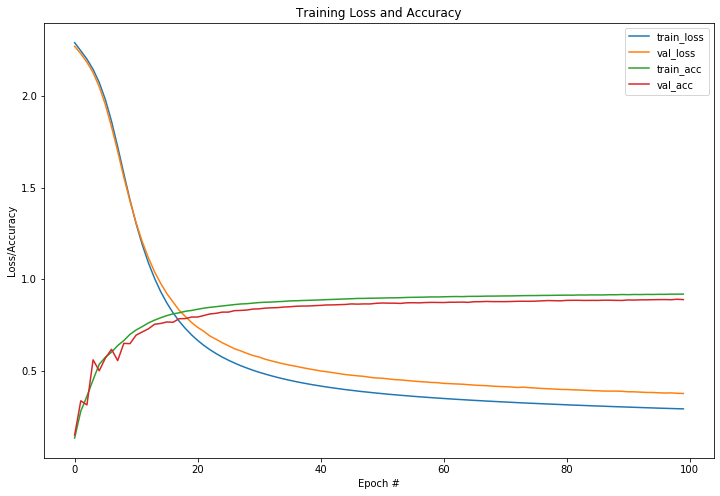

In [15]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [16]:
testY.shape

(5000, 10)

In [17]:
predictions.shape

(5000, 10)